# Reference
Ising formulations of many NP problems  
Andrew Lucas  
https://arxiv.org/abs/1302.5843

# Maxcut
The maxcut problem is to see if you can cross as many edges as possible in a single stroke.

## Hamiltonian
The hamiltonian of maxcut is

$$H = -\sum_{i,j}\frac{1}{2}(1-z_iz_j)$$

z takes a value of 1 or -1, corresponding to the value of each vertex.

## Example
Let's solve a graph problem with five points and six edges. First, let's draw the graph.

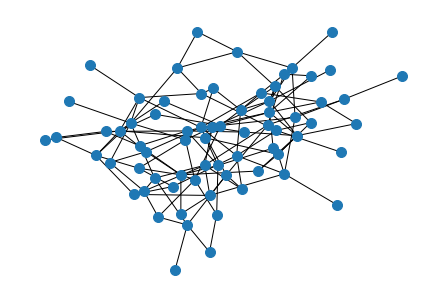

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

n = 70
m = 130
seed = 14

options = {'node_size': 100}

G = nx.gnm_random_graph(n, m, seed = seed)
nx.draw(G, **options)

## Solving with a simulator
Here, we will use QAOA to solve the problem on a simulator.

sample:0000001111000101011110000111101010000010110111111001101010100100111011


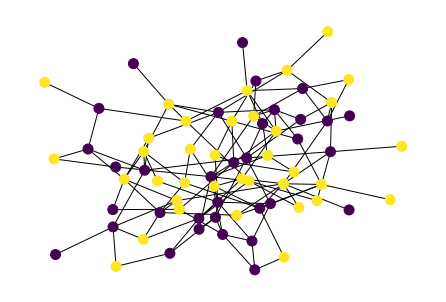

In [2]:
from blueqat.pauli import Z
from blueqat.utils import qaoa
import numpy as np
import time

hamiltonian = sum(Z[e[0]]*Z[e[1]] for e in G.edges)
step = 1

result = qaoa(hamiltonian, step)
b = result.circuit.run(shots=10)
sample = b.most_common(1)[0][0]

print("sample:"+ str(sample))

nx.draw(G, **options, node_color=[int(s) for s in list(sample)])

The edges between the vertices of different colors will be cut.

# Exact Cover

We are given a set $ U = {1,....,n}$ and we are also given a number of sets $V_i \in U \{1,....,n\}$. The problem states that if we form a set of sets of the above given sets, is there a subset of the above set whose elements are disjoint sets and the union of the sets is U.

## QUBO

We have a binary variable $q_i$ which is $1$ if the given subset $V_i$ is included and 0 otherwise. Considering the sets are disjoint and an element of the set $U$ belongs to just one set, we define the Hamiltonian of the given problem in the following way:
$$ H = \sum_{\alpha=1}^{n} ( 1 - \sum_{i:\alpha\in V_i} q_i)^2$$

## Solving with a simulator
Here, we will use QAOA to solve the problem on a simulator.

In [3]:
import numpy as np
from blueqat.pauli import qubo_bit as q
from blueqat.utils import qaoa

U = np.array([1, 2, 3])
V_size = 3

V = np.array([[1,2],[1],[3]],dtype=object)

hamiltonian = 0.0
temp = 0.0
for i in range(U.size):
    for j in range(V.size):
        if((np.where(V[j] == U[i]))[0].size > 0):
            temp+= q(j)
    hamiltonian += (1 - temp)**2
    temp = 0.0

In [4]:
step = 1

result = qaoa(hamiltonian, step)
b = result.circuit.run(shots=10)
sample = b.most_common(1)[0][0]
print(sample)

101


# Graph Coloring

We are given an undirected graph $G=(V,E)$ where $V$ is the set of vertices and $E$ is the set of edges. Given $n$ colors, is it possible to color the graph such that no two adjacent vertices have the same color. It is a NP-Complete problem as it's a generalization of the NP-Hard problem, how many colors are needed to color the graph in the respective manner. 

## QUBO

$n$ is the number of vertices and $m$ is the number of colors.
We take a binary variable $x_{v,i}$ for each element in a vertex-color matrix. Thus the total number of qubits that will be used are $n*m$.

We have two main constraints:
1. Every vertex should be represented by only one color.

$$ H_A = \sum_{v} (1 - \sum_{i=1}^{m} q_{v,i})^2 $$

2. Adjacent vertices should have different colours.

$$ H_B = \sum_{(uv) \in E}^{n} \sum_{i=1}^{m} q_{u,i}*q_{v,i} $$

## Solving with a simulator
Here, we will use QAOA to solve the problem on a simulator.

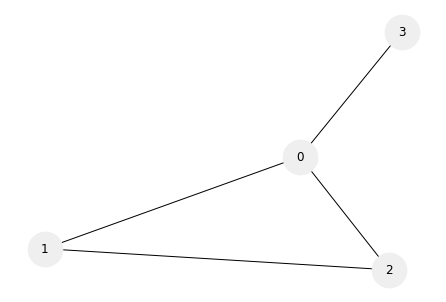

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

n = 4 #number of nodes
m = 3 #number of colors

G = nx.Graph()
G.add_nodes_from(nx.path_graph(n))
G.add_edges_from([(0,1), (0,2), (0,3),(1,2)])
nx.draw(G, **options)

In [6]:
from blueqat.utils import qaoa
from blueqat.pauli import qubo_bit as q
import numpy as np

#make an adjacent matrix
a = nx.to_numpy_matrix(G)
b = np.zeros((n,m), dtype=int)

my_dict = {}

num = 0
for v in range(n):
    for i in range(m):
        b[v][i] = num
        my_dict[num]=[str(v),i]
        num+=1

h_1= 0.0
const_h = 0.0
for v in range (n):
    for i in range(m):
        const_h = const_h + q(b[v,i])
        
    h_1 = h_1 + (1 - const_h)**2
    const_h = 0.0
        
h_2 = 0.0    
for u in range(n):
    for v in range(n):
        for i in range(m):
            if(a[u,v]==1):
                h_2 = h_2 + q(b[u,i])*q(b[v,i])
                
h = h_1 + h_2

In [58]:
step = 1

result = qaoa(h, step)
b = result.circuit.run(shots=10)

In [60]:
from blueqat import Circuit

arr = []

for samples in list(b):
    circ1 = Circuit(12)
    for i, x in enumerate(list(samples)):
        if x == '1':
            circ1.x[i]
    res = circ1.run(hamiltonian=h)
    arr.append([samples, res])
    print(samples, res)

001010100010 0.0
000000100010 2.0
000100010100 1.0
000110001001 2.0
011000001101 7.0
100000001100 3.0
010101000001 2.0
010000000000 3.0
001100010100 0.0
101001100011 8.0


In [64]:
for item in arr:
    if item[1] == 0.0:
        for i in range(n*m):
            if list(item[0])[i] == "1":
                print(my_dict[i])
        print()

['0', 2]
['1', 1]
['2', 0]
['3', 1]

['0', 2]
['1', 0]
['2', 1]
['3', 0]

